# Imports

In [1]:
import pandas as pd
import requests
import json
import csv
import time
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import scipy

In [2]:
import pandas as pd
import yfinance as yf

#Achtung!
from datetime import datetime
import datetime as dt

import time
import requests
import io
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
import nltk
from nltk.corpus import stopwords
import string

In [4]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [5]:
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [86]:
plt.rcParams["figure.figsize"] = (10,4)

# Functions

In [8]:
def addDay(row):
    day = row["Date"]
    date = datetime.strptime(day, '%Y-%m-%d') - dt.timedelta(days=1)
    return str(date)[:-9]

In [9]:
#conversts a datetime timestamp to a string in the format yyyy-mm-dd
def timestamp_to_string(date):
    return str(date)[:-9]

In [10]:
# checks if words are in the body of a comment
def check_for_words_comments(row, words):
    text = row["body"]
    
    for word in words:
        if(type(text) == str and word in text):
            return True
        
    return False

In [11]:
# converts a utc to a string in the format yyyy-mm-dd
def utc_to_string(utc):
    date = datetime.utcfromtimestamp(utc)
    return str(date)[:-9]

In [12]:
# checks if any of the words in the words list are in the title or the body of a reddit post
def check_for_words(row, words):
    title = row["title"]
    text = row["selftext"]
    
    for word in words:
        if(word in title):
            return True
        if(type(text) == str and word in text):
            return True
        
    return False

In [13]:
# perpares text for text analysis
stop_words = set(stopwords.words("english"))
def preprocess(raw_text):
    text = raw_text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens]
    return tokens

In [14]:
def preprocess_to_string(raw_text):
    tokens = preprocess(raw_text)
    return " ".join(tokens)

In [15]:
import math
def take_log(x):
    if(x > 0):
        return math.log(x)
    else:
        return 0

# Importing Data

### WSB - Posts - All

In [16]:
df = pd.read_csv("./wsb_submissions.csv")

C:\Users\paulr\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (4,68,75,77,79,82,83,84,85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
df = df[df.num_comments >= 5]

In [18]:
df = df[~df.title.isna()]

In [19]:
df["Date"] = df.created_utc.apply(lambda row: utc_to_string(row))

In [20]:
df.title = df.title.apply(lambda x : preprocess_to_string(x))

In [21]:
df.selftext = df.selftext.apply(lambda x : preprocess_to_string(x) if type(x) == str else x)

In [22]:
df = df.sort_values("Date")

In [23]:
wsb_data = df.copy()

### WSB - Posts - GME

In [24]:
df = wsb_data.copy()

In [25]:
words = ["gme", "gamestop", "game stop", "gamestonks", "game stonks"]

df["contains_gme"] = df.apply(lambda row : check_for_words(row, words), axis = 1)
df = df[df["contains_gme"]]

In [26]:
wsb_gme_data = df.copy()

### WSB - Comments - ALL

In [27]:
df = pd.read_csv("./wsb_comments/c_wallstreetbets_full.csv")

C:\Users\paulr\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (4,37,38,39,40,42,46,47,48,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
df = df[~df.body.isna()]

In [29]:
df.body = df.body.apply(lambda x : preprocess_to_string(x) if type(x) == str else x)

In [30]:
df["Date"] = df.created_utc.apply(lambda row: utc_to_string(row))

In [31]:
c_wsb_data = df.copy()

### WSB - Comments - GME

In [32]:
df = c_wsb_data.copy()

In [33]:
words = ["gme", "gamestop", "game stop", "gamestonks", "game stonks"]

df["contains_gme"] = df.apply(lambda row : check_for_words_comments(row, words), axis = 1)
df = df[df["contains_gme"]]

In [34]:
c_wsb_gme_data = df.copy()

### Game Stop

In [188]:
ts = pdr.av.time_series.AVTimeSeriesReader('BB', api_key="L4AD6ZM4H22R60UI")
df = ts.read()
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
# plotting the opening and closing value 
#df[['open','close']].plot()

In [189]:
df = df.reset_index()
df = df.rename(columns = {"index":"Date"})

In [190]:
df["Date"] = df["Date"].apply(lambda x : timestamp_to_string(x))

In [191]:
df["return"] = df.apply(lambda x : 0.0, axis = 1)
for i in range(0, len(df)-1):
    df["return"][i] = df["close"][i+1] / df["close"][i] - 1.0

C:\Users\paulr\AppData\Local\Temp\ipykernel_23380\3304754873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["return"][i] = df["close"][i+1] / df["close"][i] - 1.0


In [192]:
gme_data = df

# Building Data Sets

### WSB - Post bullish/bearish senitment

In [40]:
# Credit: https://medium.com/nerd-for-tech/wallstreetbets-sentiment-analysis-on-stock-prices-using-natural-language-processing-ed1e9e109a37
blacklist = {'I', 'ELON', 'WSB', 'THE', 'A', 'ROPE', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR','DEC', 'BE', 'IMO', 'ALL', 'RH', 'EV', 'TOS', 'CFO', 'CTO', 'DD', 'BTFD', 'WSB', 'OK', 'PDT', 'RH', 'KYS', 'FD', 'TYS', 'US', 'USA', 'IT', 'ATH', 'RIP', 'BMW', 'GDP', 'OTM', 'ATM', 'ITM', 'IMO', 'LOL', 'AM', 'BE', 'PR', 'PRAY', 'PT', 'FBI', 'SEC', 'GOD', 'NOT', 'POS', 'FOMO', 'TL;DR', 'EDIT', 'STILL', 'WTF', 'RAW', 'PM', 'LMAO', 'LMFAO', 'ROFL', 'EZ', 'RED', 'BEZOS', 'TICK', 'IS', 'PM', 'LPT', 'GOAT', 'FL', 'CA', 'IL', 'MACD', 'HQ', 'OP', 'PS', 'AH', 'TL', 'JAN', 'FEB', 'JUL', 'AUG', 'SEP', 'SEPT', 'OCT', 'NOV', 'FDA', 'IV', 'ER', 'IPO', 'MILF', 'BUT', 'SSN', 'FIFA', 'USD', 'CPU', 'AT', 'GG', 'Mar'}

# Adding wsb/reddit flavor to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {'citron': -4.0,      'hidenburg': -4.0,            'moon': 4.0,    'highs': 2.0,    'mooning': 4.0,    'long': 2.0,    'short': -2.0,    'call': 4.0,    'calls': 4.0,        'put': -4.0,    'puts': -4.0,        'break': 2.0,    'tendie': 2.0,     'tendies': 2.0,     'town': 2.0,          'overvalued': -3.0,     'undervalued': 3.0,     'buy': 4.0,     'sell': -4.0,     'gone': -1.0,     'gtfo': -1.7,     'paper': -1.7,     'bullish': 3.7,     'bearish': -3.7,'bagholder': -1.7,'stonk': 1.9,     'green': 1.9,     'money': 1.2,     'print': 2.2,     'rocket': 2.2,     'bull': 2.9,     'bear': -2.9,     'pumping': -1.0,     'sus': -3.0,     'offering': -2.3,     'rip': -4.0,     'downgrade': -3.0,     'upgrade': 3.0,          'maintain': 1.0,               'pump': 1.9,     'hot': 1.5,     'drop': -2.5,     'rebound': 1.5,       'crack': 2.5,}

In [41]:
vader = SentimentIntensityAnalyzer()
# adding custom words from data.py
vader.lexicon.update(new_words)
score = vader.polarity_scores("I am totlly bull on GME")

In [42]:
sent_dict = {}

title_dict = {}
text_dict = {}

for index, row in wsb_gme_data.iterrows():
    post_id = row["id"]
    
    title_text = row["title"]
    post_text = row["selftext"]
    if(type(title_text) == str):
        title_dict[post_id] = vader.polarity_scores(title_text)["compound"]
    
    if(type(post_text) == str and post_text not in ["[removed]", "[deleted]"]):
        text_dict[post_id] = vader.polarity_scores(post_text)["compound"]

In [43]:
wsb_gme_data["sentiment"] = wsb_gme_data.id.apply(lambda x : title_dict[x])

In [44]:
gme_sentiment = wsb_gme_data.groupby("Date")["sentiment"].mean().reset_index()

### count data sets

In [45]:
wsb_count = wsb_data.groupby("Date")["id"].count().reset_index().rename(columns={"id":"count"})
wsb_gme_count = wsb_gme_data.groupby("Date")["id"].count().reset_index().rename(columns={"id":"count"})
wsb_nan_count = wsb_data[wsb_data.selftext.isna()].groupby("Date")["id"].count().reset_index().rename(columns={"id":"count"})
c_wsb_count = c_wsb_data.groupby("Date")["id"].count().reset_index().rename(columns={"id":"count"})
c_wsb_gme_count = c_wsb_gme_data.groupby("Date")["id"].count().reset_index().rename(columns={"id":"count"})

### New Users posting

In [46]:
gme_df = gme_data.copy()
wsb_df = wsb_gme_data.copy()

In [47]:
wsb_df = wsb_df[wsb_df["Date"] >= "2021-01-01"]
wsb_df = wsb_df[wsb_df["Date"] <= "2022-01-01"]

In [48]:
dates = wsb_df["Date"].unique()
all_authors = {}
dates_dict = {}

for d in dates:
    counter = 0
    for index, row in wsb_df.iterrows():
        
        author = row["author"]
        date = row["Date"]
        if date == d:
            if author not in all_authors:
                all_authors[author] = 1
                counter += 1
        
    dates_dict[d] = counter
    print(d)

2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05
2021-01-06
2021-01-07
2021-01-08
2021-01-09
2021-01-10
2021-01-11
2021-01-12
2021-01-13
2021-01-14
2021-01-15
2021-01-16
2021-01-17
2021-01-18
2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-25
2021-01-26
2021-01-27
2021-01-28
2021-01-29
2021-01-30
2021-01-31
2021-02-01
2021-02-02
2021-02-03
2021-02-04
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-13
2021-02-14
2021-02-15
2021-02-16
2021-02-17
2021-02-18
2021-02-19
2021-02-20
2021-02-21
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-02-27
2021-02-28
2021-03-02
2021-03-03
2021-03-04
2021-03-05
2021-03-07
2021-03-08
2021-03-09
2021-03-10
2021-03-11
2021-03-12
2021-03-13
2021-03-14
2021-03-15
2021-03-16
2021-03-17
2021-03-27
2021-03-28
2021-03-29
2021-03-30
2021-03-31


In [49]:
df = pd.DataFrame()
for date in dates:
    day = {}
    day["Date"] = date
    day["new"] = dates_dict[date]
    df = df.append(day, ignore_index=True)

In [50]:
wsb_new_users = df.copy()

# Analysis

## General Overview

### Game Stop - Overview

In [257]:
gme_df = gme_data.copy()

In [258]:
gme_df = gme_df[gme_df["Date"] >= "2020-01-01"]
gme_df = gme_df[gme_df["Date"] <= "2022-01-01"]

In [255]:
gme_df["volume"] = gme_df["volume"].apply(lambda x : (x) * 100)

<AxesSubplot:xlabel='Date'>

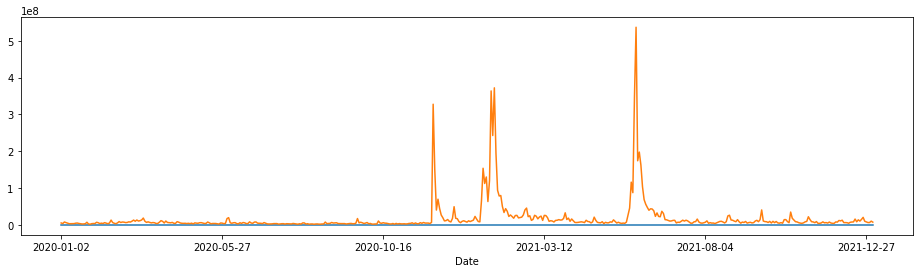

In [259]:
gme_df.groupby("Date")["close"].sum().plot(figsize=(16,4))
gme_df.groupby("Date")["volume"].sum().plot(figsize=(16,4))

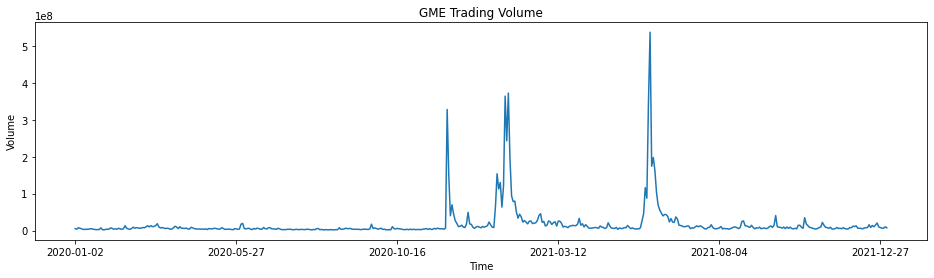

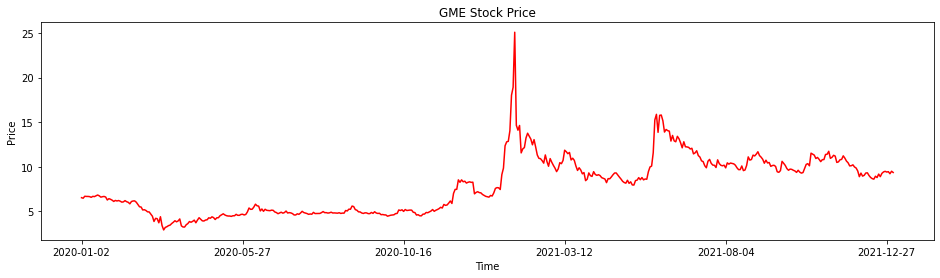

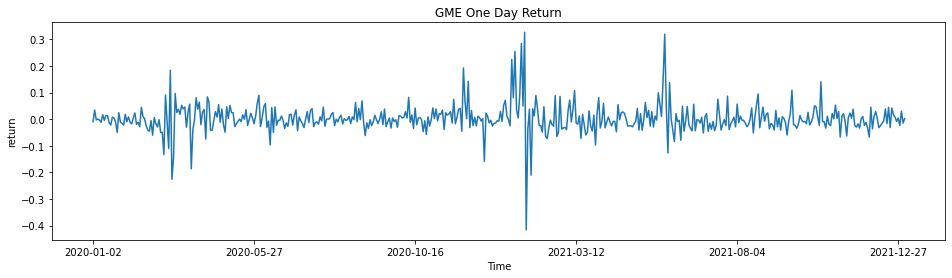

In [261]:
a = gme_df.groupby("Date")["volume"].sum().plot(figsize=(16,4))
plt.xlabel('Time') 
plt.ylabel('Volume') 
plt.title("GME Trading Volume")
plt.show()
gme_df.groupby("Date")["close"].sum().plot(figsize=(16,4), color = "red")
plt.xlabel('Time') 
plt.ylabel('Price') 
plt.title("GME Stock Price")
plt.show()
gme_df.groupby("Date")["return"].sum().plot(figsize=(16,4))
plt.xlabel('Time') 
plt.ylabel('return') 
plt.title("GME One Day Return")
plt.show()

### Wall Street Bets - Overview

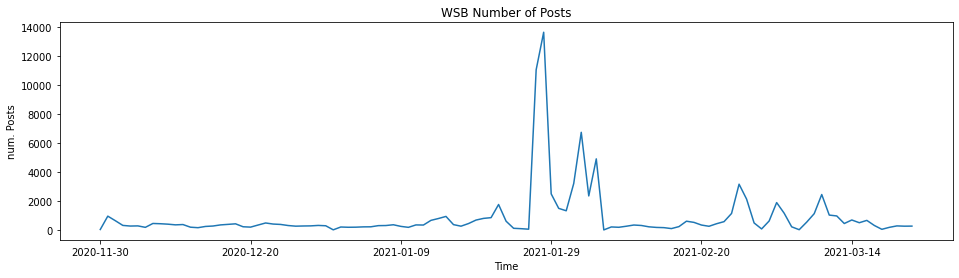

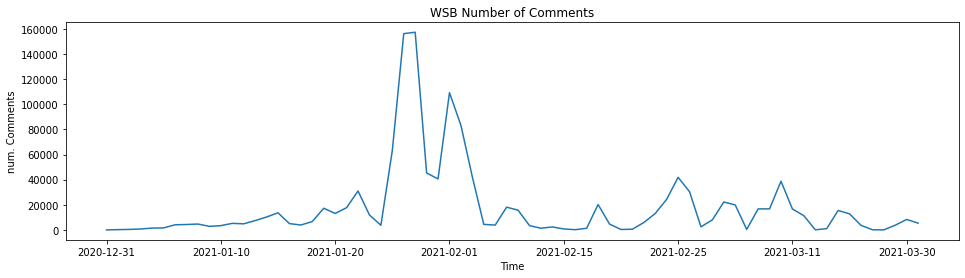

In [196]:
wsb_data.groupby("Date")["id"].count().plot(figsize=(16,4))
plt.xlabel('Time') 
plt.ylabel('num. Posts') 
plt.title("WSB Number of Posts")
plt.show()
c_wsb_data.groupby("Date")["id"].count().plot(figsize=(16,4))
plt.xlabel('Time') 
plt.ylabel('num. Comments') 
plt.title("WSB Number of Comments")
plt.show()

Text(0.5, 1.0, 'GME Sentiment of Posts')

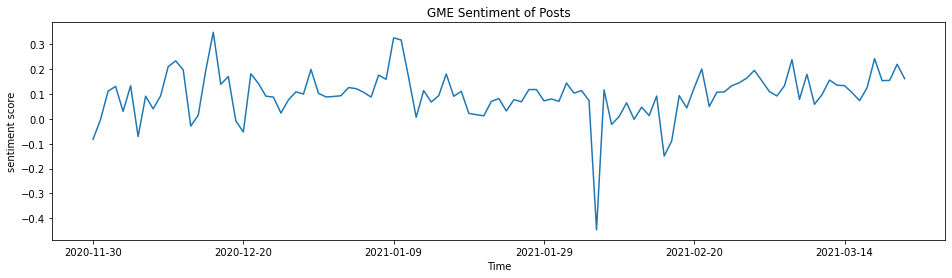

In [197]:
gme_sentiment.groupby("Date")["sentiment"].sum().plot(figsize=(16,4))
plt.xlabel('Time') 
plt.ylabel('sentiment score') 
plt.title("GME Sentiment of Posts")

#### show topic distribution

In [198]:
merge = wsb_count.merge(wsb_gme_count, left_on="Date", right_on="Date")#.merge(c_wsb_nan_count, left_on="Date", right_on="Date")
merge["ratio_gme"] = merge.apply(lambda row: row["count_y"]/row["count_x"], axis=1)
#merge["ratio_nan"] = merge.apply(lambda row: 1 - row["count"]/row["count_x"], axis=1)
merge["one"] = merge.Date.apply(lambda row: 1.0)

ratio of posts that deal with gme


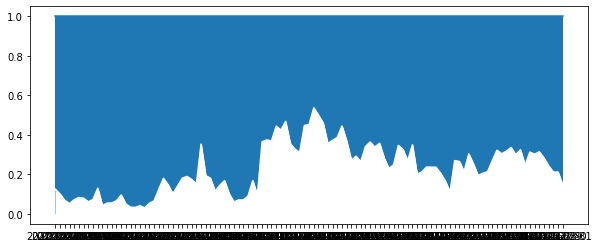

In [199]:
dates = merge["Date"].tolist()
ratio_gme = merge["ratio_gme"].tolist()
#ratio_nan = merge["ratio_nan"].tolist()
one = merge["one"].tolist()

print("ratio of posts that deal with gme")
plt.plot(dates, one)
plt.plot(dates, ratio_gme,color="white")
plt.fill_between(dates, one)
plt.fill_between(dates, ratio_gme,color="white")

# Statistical Significance

### 1. new Users on WSB

$Trading Volume_{T+2} = \beta_0 + \beta_1 New Users_T + \epsilon$

In [200]:
df_gme = gme_data.copy()
df_new = wsb_new_users.copy()
df_sentiment = gme_sentiment.copy()

In [201]:
# um ein tag verschieben
#df_new["Date"] = df_new.apply(lambda row : addDay(row), axis = 1)
df_new["Date"] = df_new.apply(lambda row : addDay(row), axis = 1)

In [202]:
merge = df_gme.merge(df_new).merge(df_sentiment)

In [203]:
merge["new"] = np.log(merge["new"])

In [204]:
#merge["volume"] = np.log(merge["volume"])
#merge["close"] = np.log(merge["close"])
#visualize:
#mu, sigma = scipy.stats.norm.fit(data)
#best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
#plt.plot(bins, best_fit_line)

In [205]:
merge = merge[merge["Date"] >= "2021-01-01"]
merge = merge[merge["Date"] <= "2021-02-15"]

In [206]:
merge["volume"] = merge["volume"].apply(lambda x : x-1)
#merge["new"] = merge["new"].apply(lambda x : x)

In [207]:
X = merge["new"]
y = merge["volume"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
#est2.pvalues.new

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     6.718
Date:                Tue, 19 Jul 2022   Prob (F-statistic):             0.0157
Time:                        17:38:27   Log-Likelihood:                -532.36
No. Observations:                  27   AIC:                             1069.
Df Residuals:                      25   BIC:                             1071.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.143e+07   5.63e+07     -0.914      0.3

<AxesSubplot:>

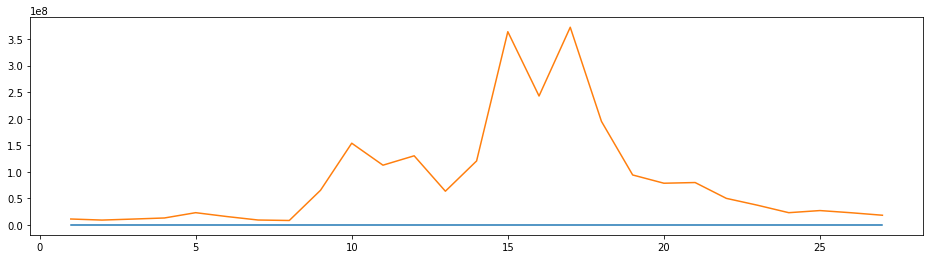

In [208]:
merge["new"].plot(figsize=(16,4))
merge["volume"].plot(figsize=(16,4))
#merge["return"].plot(figsize=(16,4))
#merge["return"].plot(figsize=(16,4))

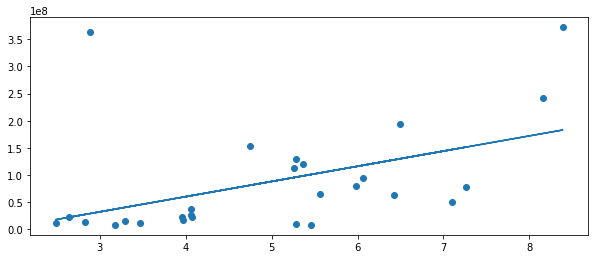

In [209]:
x = np.array(merge["new"])
y = np.array(merge["volume"])
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, est2.params.new*x+est2.params.const) 

### 2. relative Frequency

In [222]:
words = ["short squeeze"]

In [223]:
gme_df = gme_data.copy()
wsb_df = wsb_gme_data.copy()

In [224]:
dates = wsb_df["Date"].unique()
freq_dict = {}
total_count = {}

for date in dates:
    total_count[date] = 0
    freq_dict[date] = {}
    for word in words:
        freq_dict[date][word] = 0
    

for index, row in wsb_df.iterrows():
    title = row["title"]
    text = row["selftext"]
    date = row["Date"]
    
    total_count[date] +=1.
    
    for word in words:
        if word in title:
            freq_dict[date][word] += 1
        elif type(text) == str and word in text:
            freq_dict[date][word] += 1

for date in dates:
    for word in words:
        freq_dict[date][word] /= total_count[date]

In [225]:
final = pd.DataFrame()

for date in dates:
    day = {}
    day["Date"] = date
    
    for word in words:
        day[word] = freq_dict[date][word]
    
    final = final.append(day, ignore_index=True)

In [226]:
final["Date"] = final.apply(lambda row : addDay(row), axis = 1)

In [227]:
merge = gme_data.merge(final)

In [228]:
merge["close"] = merge["close"].apply(lambda x : x/1000)

In [229]:
merge["volume"] = merge["volume"].apply(lambda x : x/300000000)

##### log transform data

In [230]:
merge["volume"] = np.log(merge["volume"])

In [231]:
merge["buy"].hist()

KeyError: 'buy'

In [232]:
merge = merge[merge["Date"] >= "2021-01-10"]
merge = merge[merge["Date"] <= "2021-02-15"]

<AxesSubplot:xlabel='Date'>

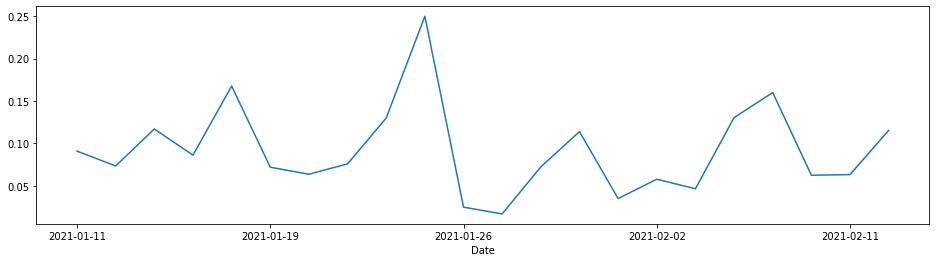

In [235]:
merge.groupby("Date")["short squeeze"].sum().plot(figsize=(16,4))

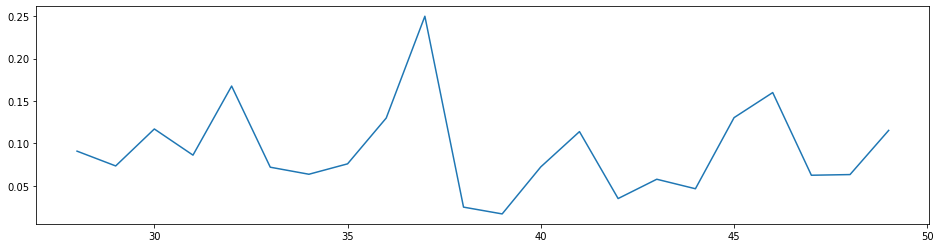

In [233]:
#merge["close"].plot(figsize=(16,4))
for word in words:
    merge[word].plot(figsize=(16,4))

In [82]:
X = merge[words]
y = merge["volume"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     1.373
Date:                Tue, 19 Jul 2022   Prob (F-statistic):              0.305
Time:                        16:43:10   Log-Likelihood:                -24.138
No. Observations:                  22   AIC:                             70.28
Df Residuals:                      11   BIC:                             82.28
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.4814      1.877     -3.452

In [83]:
X = merge[words]
y = merge["return"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     1.775
Date:                Tue, 19 Jul 2022   Prob (F-statistic):              0.180
Time:                        16:43:13   Log-Likelihood:                 20.216
No. Observations:                  22   AIC:                            -18.43
Df Residuals:                      11   BIC:                            -6.430
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0731      0.250     -0.292

In [84]:
X = merge[words]
y = merge["close"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     2.003
Date:                Tue, 19 Jul 2022   Prob (F-statistic):              0.135
Time:                        16:43:16   Log-Likelihood:                 102.30
No. Observations:                  22   AIC:                            -182.6
Df Residuals:                      11   BIC:                            -170.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0058      0.006      0.963

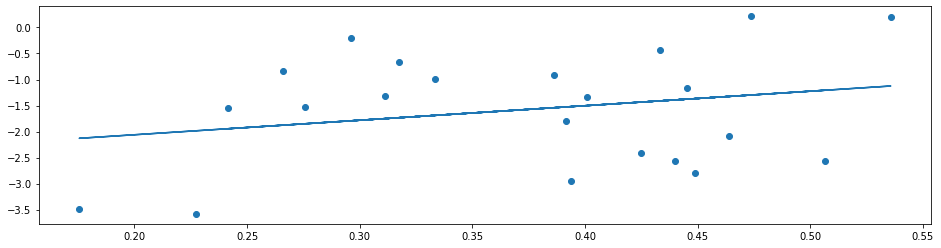

In [85]:
import numpy as np
import matplotlib.pyplot as plt

#define data
x = np.array(merge["buy"])
y = np.array(merge["volume"])

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add points to plot
plt.scatter(x, y)

#add line of best fit to plot
plt.plot(x, a*x+b) 

# Power Law

In [97]:
gme_data = wsb_gme_data.copy()

In [98]:
#gme_data = gme_data[gme_data.Date >= "2021-01-15"]
#gme_data = gme_data[gme_data.Date <= "2021-01-31"]

In [99]:
comments_df = gme_data.groupby(["Date", "author"])["num_comments"].sum().reset_index()

In [100]:
comments_df

,Date,author,num_comments
0,2020-11-30,Denvas4012,6
1,2020-11-30,LiberLilith,13
2,2020-11-30,applecees6,13
3,2020-11-30,encore2097,27
4,2020-11-30,ronoron,16
...,...,...,...
25042,2021-03-31,komoru-1,11
25043,2021-03-31,maksu22,48
25044,2021-03-31,nelwitch22,11
25045,2021-03-31,sundevilsucker,121


C:\Users\paulr\AppData\Local\Temp\ipykernel_23380\4009438165.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comments_df[comments_df.Date >= "2021-01-00"][comments_df.Date < "2021-01-05"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color="#79AFFF")


<AxesSubplot:>

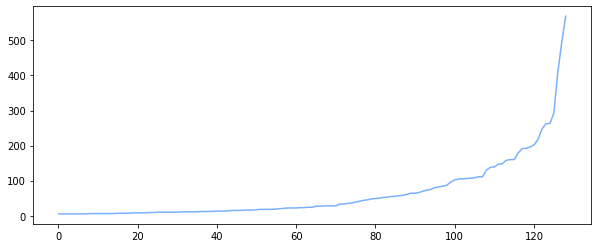

In [111]:
comments_df[comments_df.Date >= "2021-01-00"][comments_df.Date < "2021-01-05"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color="#79AFFF")

C:\Users\paulr\AppData\Local\Temp\ipykernel_23380\1014416815.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comments_df[comments_df.Date >= "2021-01-05"][comments_df.Date < "2021-01-10"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color = "#1574FF")


<AxesSubplot:>

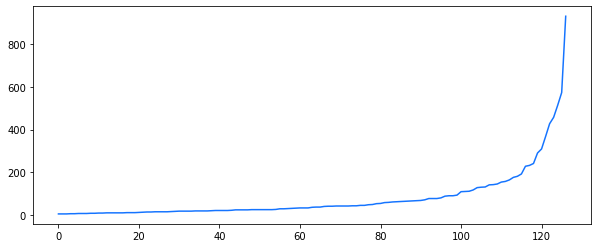

In [112]:
comments_df[comments_df.Date >= "2021-01-05"][comments_df.Date < "2021-01-10"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color = "#1574FF")

C:\Users\paulr\AppData\Local\Temp\ipykernel_23380\1356466722.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comments_df[comments_df.Date >= "2021-01-10"][comments_df.Date < "2021-01-15"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color="#0049B4")


<AxesSubplot:>

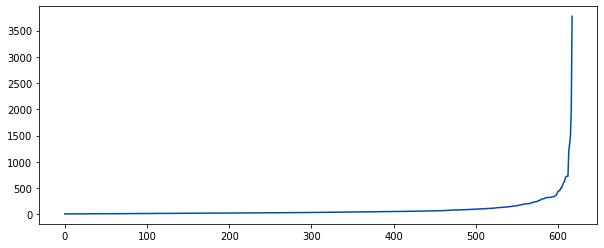

In [113]:
comments_df[comments_df.Date >= "2021-01-10"][comments_df.Date < "2021-01-15"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color="#0049B4")

C:\Users\paulr\AppData\Local\Temp\ipykernel_23380\1650438767.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comments_df[comments_df.Date >= "2021-01-15"][comments_df.Date < "2021-01-20"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color="#00255C")


<AxesSubplot:>

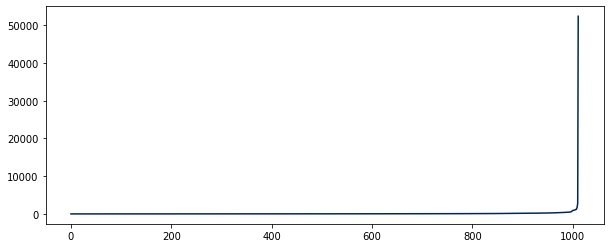

In [114]:
comments_df[comments_df.Date >= "2021-01-15"][comments_df.Date < "2021-01-20"]["num_comments"].sort_values().reset_index()["num_comments"].plot(color="#00255C")

C:\Users\paulr\AppData\Local\Temp\ipykernel_35344\1527360416.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comments_df[comments_df.Date >= "2021-01-20"][comments_df.Date < "2021-01-25"]["num_comments"].sort_values().reset_index()["num_comments"].plot()


<AxesSubplot:>

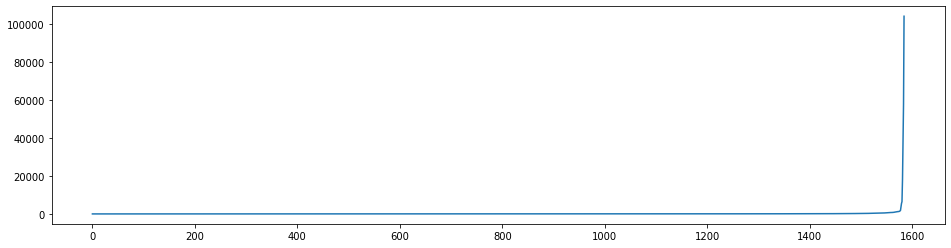

In [105]:
comments_df[comments_df.Date >= "2021-01-20"][comments_df.Date < "2021-01-25"]["num_comments"].sort_values().reset_index()["num_comments"].plot()

C:\Users\paulr\AppData\Local\Temp\ipykernel_23380\4238160161.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  comments_df[comments_df.Date >= "2021-01-25"][comments_df.Date < "2021-01-30"]["num_comments"].sort_values().reset_index()["num_comments"].plot()


<AxesSubplot:>

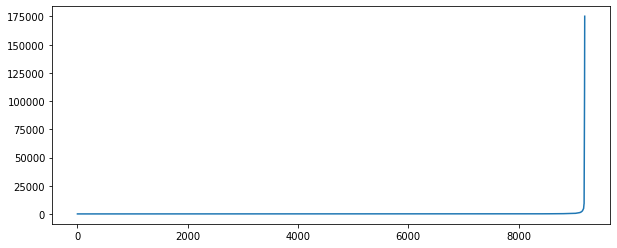

In [115]:
comments_df[comments_df.Date >= "2021-01-25"][comments_df.Date < "2021-01-30"]["num_comments"].sort_values().reset_index()["num_comments"].plot()

<AxesSubplot:xlabel='author'>

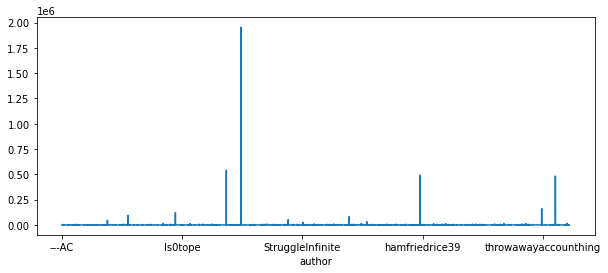

In [116]:
comments_df.groupby("author")["num_comments"].sum().plot()

<AxesSubplot:xlabel='author'>

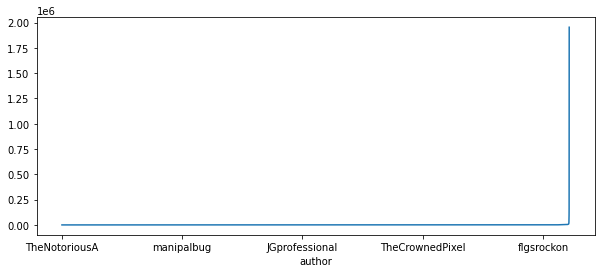

In [117]:
authors_sorted = comments_df.groupby("author")["num_comments"].sum().sort_values()
authors_sorted.plot()

In [118]:
total_comments = comments_df["num_comments"].sum()

In [119]:
count = 0
authors = 0
found_90 = False
found_95 = False
found_99 = False

for com in reversed(authors_sorted):
    authors += 1
    count += com
    
    if(not found_90 and total_comments*0.9 < count):
        print("90% at " + str(authors))
        found_90 = True
        
    
    if( not found_95 and total_comments*0.95 < count):
        print("95% at " + str(authors))
        found_95 = True
        
    
    if(not found_99 and total_comments*0.99 < count):
        print("99% at " + str(authors))
        found_99 = True

print("total authors:" + str(len(authors_sorted)))

90% at 1842
95% at 4239
99% at 12502
total authors:21089


In [120]:
dates = comments_df["Date"]
top_authors = pd.DataFrame(columns=["author","num_comments"])

daily_authors = comments_df[comments_df.Date == "2021-01-20"][["author","num_comments"]].sort_values('num_comments')[-10:]
top_authors = top_authors.append(daily_authors)
daily_authors = comments_df[comments_df.Date == "2021-01-21"][["author","num_comments"]].sort_values('num_comments')[-10:]
top_authors = top_authors.append(daily_authors)

top_authors

,author,num_comments
2881,Hairy-Philosopher-72,343
3053,shinereps,388
2960,Unlucky-Prize,470
2890,ImmortalCupcake,490
2952,TonyMiller81,545
2961,Vagabond_Hospitality,546
3057,spike142,621
2900,Kabdckmd,764
3033,only1parkjisung,955
2889,ITradeBaconFutures,36479


In [121]:
dates = comments_df["Date"].unique()
top_authors = pd.DataFrame(columns=["author","num_comments"])

for date in dates:
    print(date)
    daily_authors = comments_df[comments_df.Date == date][["author","num_comments"]].sort_values('num_comments')[-20:]
    
    top_authors = top_authors.append(daily_authors)

top_authors

2020-11-30
2020-12-01
2020-12-02
2020-12-03
2020-12-04
2020-12-05
2020-12-06
2020-12-07
2020-12-08
2020-12-09
2020-12-10
2020-12-11
2020-12-12
2020-12-13
2020-12-14
2020-12-15
2020-12-16
2020-12-17
2020-12-18
2020-12-19
2020-12-20
2020-12-21
2020-12-22
2020-12-23
2020-12-24
2020-12-25
2020-12-26
2020-12-27
2020-12-28
2020-12-29
2020-12-30
2020-12-31
2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05
2021-01-06
2021-01-07
2021-01-08
2021-01-09
2021-01-10
2021-01-11
2021-01-12
2021-01-13
2021-01-14
2021-01-15
2021-01-16
2021-01-17
2021-01-18
2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-25
2021-01-26
2021-01-27
2021-01-28
2021-01-29
2021-01-30
2021-01-31
2021-02-01
2021-02-02
2021-02-03
2021-02-04
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-13
2021-02-14
2021-02-15
2021-02-16
2021-02-17
2021-02-18
2021-02-19
2021-02-20
2021-02-21
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-02-27
2021-02-28
2021-03-02
2021-03-03

,author,num_comments
0,Denvas4012,6
1,LiberLilith,13
2,applecees6,13
4,ronoron,16
3,encore2097,27
...,...,...
25011,Baarluh,244
25010,Apeguru123,537
25025,JuxtaposeLife,988
25017,DeepFuckingValue,4334


In [122]:
len(top_authors)

2028

In [123]:
len(top_authors["author"].unique())

1600

In [150]:
l = top_authors.author.value_counts()
text = ""
for i in range(0, 30):
    for n in range(0, l[i]):
        text += l.index[i] + ", "

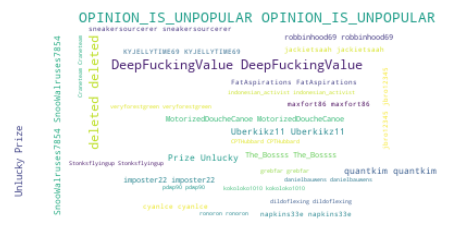

In [151]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#text = "OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR OPINION_IS_UNPOPULAR DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue DeepFuckingValue Uberkikz11 Uberkikz11 Uberkikz11 Uberkikz11 Uberkikz11 Uberkikz11 Uberkikz11 Uberkikz11 Unlucky-Prize Unlucky-Prize Unlucky-Prize Unlucky-Prize Unlucky-Prize Unlucky-Prize Unlucky-Prize Unlucky-Prize SnooWalruses7854 SnooWalruses7854 SnooWalruses7854 SnooWalruses7854 SnooWalruses7854 SnooWalruses7854 SnooWalruses7854 SnooWalruses7854 quantkim quantkim quantkim quantkim quantkim quantkim quantkim quantkim The_Bossss The_Bossss The_Bossss The_Bossss The_Bossss The_Bossss The_Bossss MotorizedDoucheCanoe MotorizedDoucheCanoe MotorizedDoucheCanoe MotorizedDoucheCanoe MotorizedDoucheCanoe MotorizedDoucheCanoe MotorizedDoucheCanoe robbinhood69 robbinhood69 robbinhood69 robbinhood69 robbinhood69 robbinhood69 robbinhood69 imposter22 imposter22 imposter22 imposter22 imposter22 imposter22 imposter22 jackietsaah jackietsaah jackietsaah jackietsaah jackietsaah jackietsaah napkins33e napkins33e napkins33e napkins33e napkins33e napkins33e maxfort86 maxfort86 maxfort86 maxfort86 maxfort86 maxfort86 cyanlce cyanlce cyanlce cyanlce cyanlce cyanlce jbro12345 jbro12345 jbro12345 jbro12345 jbro12345 jbro12345 KYJELLYTIME69 KYJELLYTIME69 KYJELLYTIME69 KYJELLYTIME69 KYJELLYTIME69 KYJELLYTIME69 FatAspirations FatAspirations FatAspirations FatAspirations FatAspirations FatAspirations sneakersourcerer sneakersourcerer sneakersourcerer sneakersourcerer sneakersourcerer sneakersourcerer pdwp90 pdwp90 pdwp90 pdwp90 pdwp90 "


wordcloud = WordCloud(background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<AxesSubplot:>

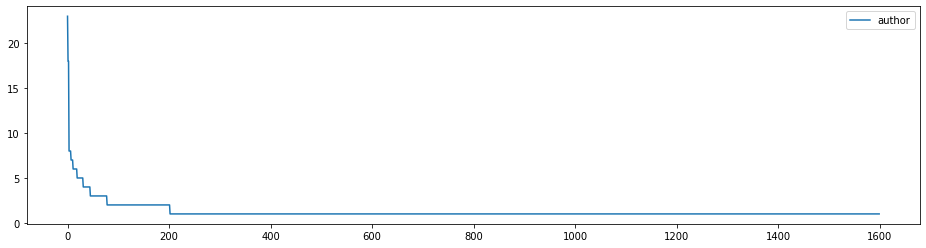

In [114]:
top_authors.author.value_counts().reset_index().plot()

In [115]:
total_comments

6749249

In [116]:
comments_df.groupby("author").num_comments.sum().reset_index().sort_values('num_comments')

,author,num_comments
10544,TheNotoriousA,5
1144,BS_Degree,5
19762,thealaskanlumberjack,5
11742,YangGiou,5
6056,Live-On-Pool,5
...,...,...
19944,theycallmeryan,160612
20513,wallstreetboyfriend,482549
14890,grebfar,491063
6834,MotorizedDoucheCanoe,541012


In [117]:
comments_df[comments_df.author == "OPINION_IS_UNPOPULAR"]["num_comments"].sum()

1953467

In [880]:
comments_df[comments_df.author == "DeepFuckingValue"]["num_comments"].sum()

95355

# Impact on external, related parties: 

In [152]:
df = pd.read_csv("robinhood_data.csv")

C:\Users\paulr\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (80,82,83,86,87,88,89,90,91,92,93,94,95,96,97,100,101,102,104,106,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [153]:
df

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,...,gallery_data,rpan_video,collections,is_created_from_ads_ui,event_end,event_is_live,event_start,author_is_blocked,category,is_survey_ad
0,0,[],False,BigJoeBalliN,NaN,[],NaN,text,t2_5j3h8cg2,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,IowaFarmboy,NaN,[],NaN,text,t2_a90rg,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,fullsendwrx,NaN,[],NaN,text,t2_6iv0ud4t,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577746,77086,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577747,77087,[],False,Homemadeduck102,NaN,[],NaN,text,t2_2x3h512q,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577748,77088,[],False,Popular-Ad1061,NaN,[],NaN,text,t2_a0fxbhey,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577749,77089,[],False,GeneralKoei,NaN,[],NaN,text,t2_1hxaim08,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
vader = SentimentIntensityAnalyzer()
# adding custom words from data.py
score = vader.polarity_scores("I am totlly bull on GME")

In [155]:
score["compound"]

0.0

In [156]:
df["sentiment"] = df.title.apply(lambda x : vader.polarity_scores(x)["compound"])

In [157]:
df["Date"] = df.created_utc.apply(lambda row: utc_to_string(row))

In [160]:
df = df[df.Date <= "2021-07-01"]
df = df[df.Date >= "2020-09-01"]

<AxesSubplot:xlabel='Date'>

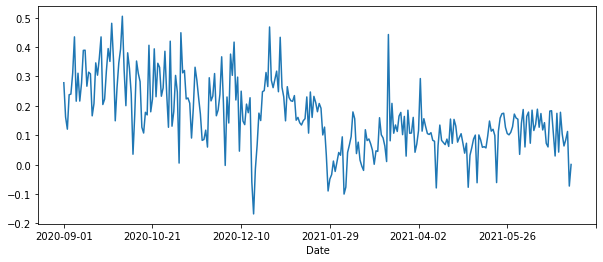

In [161]:
df.groupby("Date")["sentiment"].mean().plot()

## Count Posts

In [21]:
date_count = wsb_gme_data.groupby("Date")["id"].count().reset_index()

## Plot Sentiment

In [1334]:
merge = date_sentiment.merge(gme_data)

In [325]:
merge = merge[merge["Date"] >= "2021-01-01"]
merge = merge[merge["Date"] <= "2021-03-01"]

In [ ]:
merge["volume"] = merge["volume"].apply(lambda x : 0.5 *(x))

In [66]:
merge["sentiment"] = merge["sentiment"].apply(lambda x : x*1000000000)

In [ ]:
merge["return"] = merge["return"].apply(lambda x : take_log(x))

In [ ]:
merge["high"] = merge["high"].apply(lambda x : 10 * (x))

<AxesSubplot:xlabel='Date'>

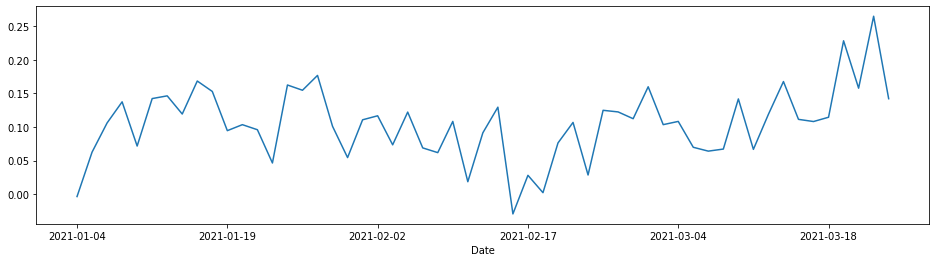

In [1335]:
merge.groupby("Date")["sentiment"].sum().plot(figsize=(16,4))
#merge.groupby("Date")["volume"].sum().plot(figsize=(16,4))
#merge.groupby("Date")["volume"].sum().plot(figsize=(16,4))
#merge.groupby("Date")["high"].sum().plot(figsize=(16,4))

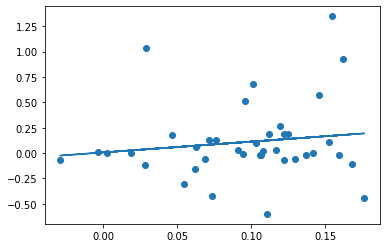

In [328]:
import numpy as np
import matplotlib.pyplot as plt

#define data
x = np.array(merge["sentiment"])
y = np.array(merge["return"])

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add points to plot
plt.scatter(x, y)

#add line of best fit to plot
plt.plot(x, a*x+b) 

In [1491]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = merge["sentiment"]
y = merge["return"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                 0.0003084
Date:                Tue, 28 Jun 2022   Prob (F-statistic):              0.986
Time:                        14:05:35   Log-Likelihood:                -16.675
No. Observations:                  53   AIC:                             37.35
Df Residuals:                      51   BIC:                             41.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0938      0.083      1.129      0.2

## Plot count

In [35]:
word = "buy"

In [36]:
gme_df = gme_data.copy()
wsb_df = wsb_gme_data.copy()

In [37]:
# Achtung um ein Tag verschieben:
def addDay(row):
    day = row["Date"]
    date = datetime.strptime(day, '%Y-%m-%d') + dt.timedelta(days=1)
    return str(date)[:-9]

wsb_df["Date"] = wsb_df.apply(lambda row : addDay(row), axis = 1)

In [38]:
wsb_df = wsb_df[wsb_df["Date"] >= "2021-01-01"]
wsb_df = wsb_df[wsb_df["Date"] <= "2021-03-01"]

In [39]:
dates = wsb_df["Date"]
date_dict = {}

for date in dates:
    date_dict[date] = 0

In [40]:
word = ""
for index, row in wsb_df.iterrows():
    title = row["title"]
    text = row["selftext"]
    date = row["Date"]
    
    if word in title:
        date_dict[date] += 1
    elif type(text) == str and word in text:
        date_dict[date] += 1

    

gme_df["count"] = gme_df.Date.apply(lambda date : date_dict[date] if date in date_dict else 0)
gme_df = gme_df[gme_df["Date"] >= "2021-01-01"]
gme_df = gme_df[gme_df["Date"] <= "2021-03-01"]

In [317]:
gme_df["count"] = gme_df["count"].apply(lambda x : x/10.0)

<AxesSubplot:xlabel='Date'>

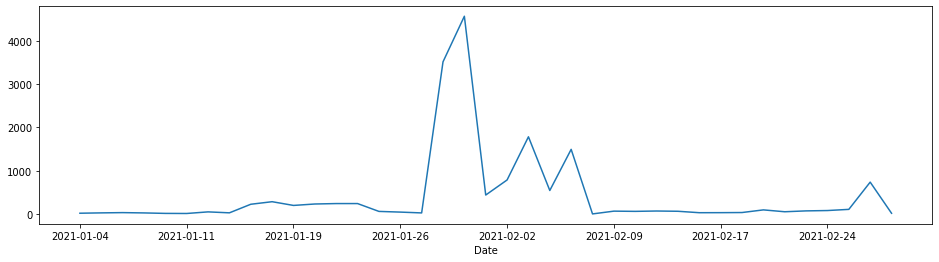

In [41]:
gme_df.groupby("Date")["count"].sum().plot(figsize=(16,4))
#gme_df.groupby("Date")["word_count"].sum().plot(figsize=(16,4))

In [ ]:
# Achtung um ein Tag verschieben:
def addDay(row):
    day = row["Date"]
    date = datetime.strptime(day, '%Y-%m-%d') + dt.timedelta(days=1)
    return str(date)[:-9]

date_sentiment["Date"] = date_sentiment.apply(lambda row : addDay(row), axis = 1)

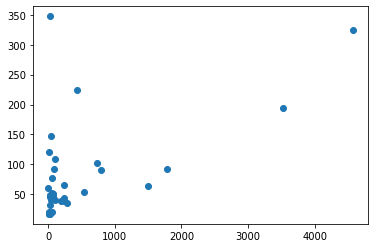

In [42]:
matplotlib.pyplot.scatter(x = gme_df["count"], y = gme_df["close"])

In [43]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

diabetes = datasets.load_diabetes()
X = gme_df["count"]
y = gme_df["close"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     18.16
Date:                Sun, 26 Jun 2022   Prob (F-statistic):           0.000134
Time:                        20:32:44   Log-Likelihood:                -216.23
No. Observations:                  39   AIC:                             436.5
Df Residuals:                      37   BIC:                             439.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.0616     11.174      5.107      0.0

## relative frequency

In [586]:
# significant results: buy -> close, open, return
# squeeze -> close
# invest -> return

## New Users

In [428]:
gme_df = gme_data.copy()
wsb_df = wsb_gme_data.copy()

In [432]:
dates = wsb_df["Date"].unique()
dates

array(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
       '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
       '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11',
       '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
       '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19',
       '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23',
       '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27',
       '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31',
       '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
       '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10',
       '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14',
       '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18',
       '2021-02-19', '2021-02-20', '2021-02-21', '2021-02-22',
       '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26',
       '2021-02-27', '2021-02-28', '2021-03-02', '2021-03-03',
       '2021-03-04', '2021-03-05', '2021-03-07', '2021-

In [438]:
dates = wsb_df["Date"].unique()
all_authors = {}
dates_dict = {}

for d in dates:
    counter = 0
    for index, row in wsb_df.iterrows():
        
        author = row["author"]
        date = row["Date"]
        if date == d:
            if author not in all_authors:
                all_authors[author] = 1
                counter += 1
        
    dates_dict[d] = counter
    print(d)

2020-12-31
2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05
2021-01-06
2021-01-07
2021-01-08
2021-01-09
2021-01-10
2021-01-11
2021-01-12
2021-01-13
2021-01-14
2021-01-15
2021-01-16
2021-01-17
2021-01-18
2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-25
2021-01-26
2021-01-27
2021-01-28
2021-01-29
2021-01-30
2021-01-31
2021-02-01
2021-02-02
2021-02-03
2021-02-04
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-13
2021-02-14
2021-02-15
2021-02-16
2021-02-17
2021-02-18
2021-02-19
2021-02-20
2021-02-21
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-02-27
2021-02-28
2021-03-02
2021-03-03
2021-03-04
2021-03-05
2021-03-07
2021-03-08
2021-03-09
2021-03-10
2021-03-11
2021-03-12
2021-03-13
2021-03-14
2021-03-15
2021-03-16
2021-03-17
2021-03-27
2021-03-28
2021-03-29
2021-03-30
2021-03-31


In [1267]:
df = pd.DataFrame()
for date in dates:
    day = {}
    day["Date"] = date
    day["new"] = dates_dict[date]
    df = df.append(day, ignore_index=True)

<AxesSubplot:>

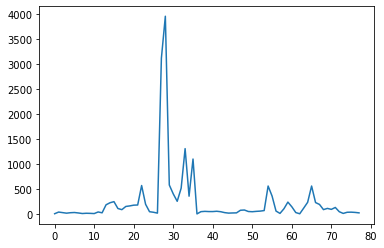

In [1268]:
df["new"].plot()

<AxesSubplot:>

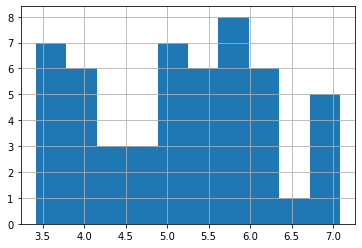

In [1015]:
merge["volume"].hist()

## compare comment sentiment to post sentiment

In [1017]:
comments_df = pd.read_csv("./wsb_comments/c_wallstreetbets_full.csv")

C:\Users\paulr\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (4,37,38,39,40,42,46,47,48,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [1024]:
comments_df = comments_df[~comments_df.body.isna()]

In [1026]:
def check_for_words_comments(row, words):
    text = row["body"]
    
    for word in words:
        if(type(text) == str and word in text):
            return True
        
    return False

In [1027]:
words = ["GME", "Gamestop", "game stop", "Game stop"]

comments_df["contains_gme"] = comments_df.apply(lambda row : check_for_words_comments(row, words), axis = 1)
comments_df = comments_df[comments_df["contains_gme"]]

In [1037]:
comments_df.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'comment_type',
       'created_utc', 'gildings', 'id', 'is_submitter', 'link_id', 'locked',
       'no_follow', 'parent_id', 'permalink', 'retrieved_on', 'score',
       'send_replies', 'stickied', 'subreddit', 'subreddit_id',
       'top_awarded_type', 'total_awards_received', 'treatment_tags',
       'distinguished', 'author_cakeday', 'archived', 'body_sha1', 'can_gild',
       'collapsed', 'collapsed_reason', 'collapsed_reason_code',
       'controversiality', 'gilded', 'retrieved_utc', 'score_hidden',
       'subreddit_name_prefixed', 'subreddit_type', 'edited', 'media_metadata',
       'contains_gme',

In [1132]:
comments_df["Date"] = comments_df.created_utc.apply(lambda row: utc_to_string(row))

In [1207]:
wsb_comments = comments_df.copy()

In [1136]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [13]:
new_words = {
    "🚀": 2.0,
    "squeeze": 2.0,
    "short":2.0,
    "buy": 2.0   
}

In [1137]:
sia = SIA()

In [1138]:
sia.lexicon.update(new_words)

In [1222]:
sent_dict = {}

text_dict = {}

for index, row in wsb_comments.iterrows():
    comment_id = row["id"]
    post_text = row["body"]
    
    if(type(post_text) == str and post_text not in ["[removed]", "[deleted]"]):
        text_dict[comment_id] = sia.polarity_scores(post_text)["compound"]
    
    

In [1208]:
wsb_comments["sentiment"] = wsb_comments.id.apply(lambda x : text_dict[x])

In [1209]:
wsb_comments["parent_id"] = wsb_comments["parent_id"].apply(lambda x: x[3:] if type(x) == str else x )

In [1210]:
sent_merge = wsb_gme_data.merge(wsb_comments, left_on="id", right_on="parent_id", how = "inner")

In [1212]:
sent_merge = sent_merge[~sent_merge["selftext"].isna()]

In [1213]:
sent_merge = sent_merge[["Date_x", "sentiment_y", "sentiment_x"]]

In [1214]:
sent_merge["sent_difference"] = sent_merge.apply(lambda row : row["sentiment_x"] - row["sentiment_y"], axis = 1)

In [1215]:
sent_merge = sent_merge.groupby("Date_x")["sent_difference"].mean().reset_index()

<AxesSubplot:>

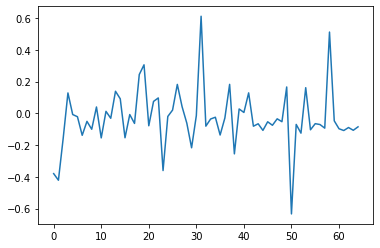

In [1221]:
sent_merge["sent_difference"].plot()

In [1332]:
pd.read_csv("/kw_robinhood/kw_robinhood.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/kw_robinhood/kw_robinhood.csv'

In [ ]:
##

In [175]:
authors = wsb_gme_data["author"]
author_dict = {}

for author in authors:
    author_dict[author] = 0

In [152]:
len(authors.unique())

1778

In [153]:
for index, row in test.iterrows():
    comments = row["num_comments"]
    author = row["author"]
    
    author_dict[author] += comments

In [157]:
num_comments_list =  sorted(num_comments_list)

In [158]:
(num_comments_list)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [156]:
num_comments_list = []
counter = 0

for author in author_dict:
    counter = author_dict[author]
    num_comments_list.append(counter)

In [159]:
df = pd.Series( num_comments_list )

<AxesSubplot:>

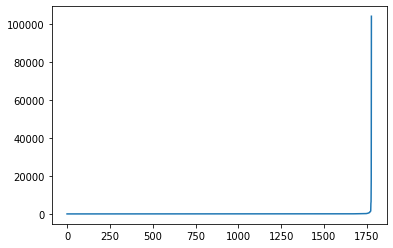

In [160]:
df.plot()

In [ ]:
from nltk.probability import FreqDist

In [ ]:
complete_list = []
counter = 0
for key in title_dict:
    complete_list = complete_list + title_dict[key]
    
    counter += 1
    if(counter > 10000):
        break;


In [ ]:
from collections import Counter

In [ ]:
complete_list

In [ ]:
sorted(Counter(complete_list).items(), key = lambda x:x[1], reverse=True)

In [ ]:
fdist = FreqDist(complete_list)

In [ ]:
fdist.plot(10, cumulative=False)

## relative frequency of word

In [ ]:
word = "buy"

In [ ]:
word_dict = {}

for key in title_dict:
    


## Preprocessing

In [15]:
stemmer = PorterStemmer()

NameError: name 'PorterStemmer' is not defined

In [ ]:
import string

In [ ]:
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(raw_text):
    text = raw_text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens]
    return tokens

In [ ]:
title_dict = {}
text_dict = {}
for index, row in df.iterrows():
    post_id = row["id"]
    
    title_text = row["title"]
    if(type(title_text) == str):
        title_dict[post_id] = preprocess(title_text)
    
    post_text = row["selftext"]
    if(type(post_text) == str and post_text not in ["[removed]", "[deleted]"]):
        text_dict[post_id] = preprocess(post_text)
    

## Word Counter

In [16]:
words = pd.DataFrame()

In [17]:
def check_word(row, word):
    title = row["title"]
    text = row["selftext"]
    
    if(word in title):
        return True
    if(type(text) == str and word in text):
        return True
        
    return False

In [19]:
df.apply(lambda row: 1 if check_word(row, "buy") else 0)

KeyError: 'title'

In [ ]:
words